<a href="https://colab.research.google.com/github/PosgradoMNA/actividades-del-projecto-equipo-41/blob/main/Reto_Entrega_1_Equipo41.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Portada
---

<br>
<p align=center>Instituto Tecnológico y de Estudios Superiores de Monterrey</p>
<p align=center>Escuela de Ingeniería y Ciencias</p>
<p align=center>
<br>
<img src="https://github.com/PosgradoMNA/actividades-del-projecto-equipo-41/blob/main/tec.png?raw=true" alt="Logo" width="250"/>
</p>
<br>
<p align=center>Maestría en Inteligencia Artificial Aplicada (MNA)</p>
<p align=center>TC4029. Ciencia y Analítica de Datos</p>
<p align=center> Profesor Titular: María de la Paz Rico </p>
<p align=center> <b>Reto Final - Parte I</b> </p>
<br>
<p align=center>Presentan:</p>
<p align=center>A01150742 | Ovalle Alvarado José</p>
<p align=center>A01793023 | Arroyo Chavelas Jorge Luis</p>
<p align=center>16 de Noviembre de 2022</p>
<br>
<br>
<p align=center><small><italic>“Por medio de la presente hacemos constar que el reporte que estamos enviando es de nuestra completa autoría y que no estamos haciendo plagio de ideas o escritos del trabajo de otras personas”</italic></small></p>

---

[GitHub Link](https://github.com/PosgradoMNA/actividades-del-projecto-equipo-41/blob/main/Reto_Entrega_1_Equipo41.ipynb)


# Introducción

En este documento, presentamos un análisis de datos de la calidad del agua para aguas subterraneas. En esta primera parte nos enfocaremos en un análisis exploratorio de los datos, pero este trabajo servirá también como base para un modelo de predicción del semaforo de calidad de la misma, por lo que la metodología irá encaminada no sólo al análisis sino a un proyecto de ciencia de datos y aprendizaje automático completo; desde su análisis exploratorio hasta la presentación de un modelo de clasificación para este semaforo.

Preapremos primero nuestro ambiente de análisis:

In [1]:
############################################################################################
# Librerias y funciones:
############################################################################################

# Para obtener los datos
import requests
import zipfile
import io

# Para manipualr datos
import pandas as pd
import numpy as np

# Para visualizaciones:
from tabulate import tabulate
from matplotlib import pyplot as plt
import seaborn as sns

# Para particiones y validaciones
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
#from sklearn.model_selection import learning_curve
#from sklearn.model_selection import validation_curve

# Para transformaciones:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import FunctionTransformer

# Para pipelines:
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer

# Otras utilidades
import functools
import warnings

sns.set_theme(style='white', palette=None)
%matplotlib inline

Obtengamos los datos:

In [2]:
############################################################################################
# Llamar los datos:
############################################################################################

# Definir la url de donde obtener los datos:
datos_url = 'http://201.116.60.46/Datos_de_calidad_del_agua_de_5000_sitios_de_monitoreo.zip'

# Obtener la respuesta:
datos_response = requests.get(datos_url, stream=True)

# Tomar respuesta como zip en cache:
datos_zip = zipfile.ZipFile(io.BytesIO(datos_response.content))

# Extraer todos los archivos del zip en nuestro espacio local:
datos_zip.extractall("./")

# Definir el lugar donde guardamos los archivos:
datos_dir = './Datos_de_calidad_del_agua_2020'

# Definir archivos a utilizar
datos_file = '/Datos_de_calidad_del_agua_de_sitios_de_monitoreo_de_aguas_subterraneas_2020.csv'

# Impotar los datos:
df = pd.read_csv(datos_dir + datos_file, encoding = "cp1252")

# Confirmemos que tenemos el dataset:
print(f'\n Dataframe con {df.shape} dimensiones')


 Dataframe con (1068, 57) dimensiones


Ahora, antes de comenzar a revisar los datos, recurramos a un poco de magía en el servidor de origen para llamar también al diccionario correspondiente a estos datos, ésto nos ayudará a dar mejores conclusiones en nuetro análisis exploratirio – Después de todo, ¿No es acaso descubrir lo creado hacer ciencia? Y esto es ciencia de datos, así que usemos lo disponible.

In [3]:
############################################################################################
# Llamar al diccionario de datos:
############################################################################################

# Definir la url de donde obtener los datos:
diccionario_url = 'http://201.116.60.46/Diccionario_Datos_de_calidad_del_agua_de_5000_sitios_de_monitoreo.zip'

# Obtener la respuesta:
diccionario_response = requests.get(diccionario_url, stream=True)

# Tomar respuesta como zip en cache:
diccionario_zip = zipfile.ZipFile(io.BytesIO(diccionario_response.content))

# Extraer todos los archivos del zip en nuestro espacio local:
diccionario_zip.extractall("./")

# Definir el lugar donde guardamos los archivos:
diccionario_dir = './Diccionario_Datos_de_calidad_del_agua_de_5000_sitios_de_monitoreo'

# Definir archivos a utilizar
diccionario_file = '/Diccionario_datos_Subterraneal.csv'

# Impotar los datos:
diccionario = pd.read_csv(diccionario_dir + diccionario_file, encoding = "UTF-8")

In [4]:
# Veamos el diccionario:
display(diccionario.head())
print(diccionario.shape)

,CAMPO,DESCRIPCION,TIPO,VALOR_POSIBLE
0,CLAVE,Clave del sitio de monitoreo,Texto,A - Z
1,SITIO,Nombre del sitio de muestreo,Texto,A - Z
2,ID_ORGANISMO_DE_CUENCA,Identificador de Organismo de Cuenca,Numerico,Entero
3,NOMBRE_ORGANISMO_DE_CUENCA,Nombre del Organismo de Cuenca de agua donde s...,Texto,A - Z
4,ID_ESTADO,Identificador de Estado,Numerico,Entero


(62, 4)


Excelente, este diccionario y un poco de técnicas exploratorias nos permitirá explicar a mayor detalle los datos que usaremos en esta entrega.

# EDA - Primeros pasos

Como ya hemos definido, el color de semaforo en las aguas será nuestra variable objetivo, lo que convierte a las demás en nuestros *features*. Esto nos permite hacer una separación en una matriz X y un vector y basado en nuestros datos. Sería además conveniente, que realicemos una separación de estos valores en conjuntos de entrenamiento y de prueba, tanto para crear un modelo más robusto en terminos de generalización, como para crear *pipelines* que nos eviten caer en problemas de *data leak* si este modelo llega a estar en producción.

In [5]:
############################################################################################
# Datos de entrenamiento y prueba:
############################################################################################

# Conjunto con features
X = df.drop('SEMAFORO', axis=1)

# Variable objetivo
y = df[['SEMAFORO']]

# Partir los datos en conjuntos de entrenamiento y prueba:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

print(f"""
Tamaño de variables de entrenamiento: {X_train.shape} || tamaño de objetivo entrenamiento: {y_train.shape}
Tamaño de variables de prueba: {X_test.shape} || tamaño de objetivo prueba: {y_test.shape}
""")


Tamaño de variables de entrenamiento: (854, 56) || tamaño de objetivo entrenamiento: (854, 1)
Tamaño de variables de prueba: (214, 56) || tamaño de objetivo prueba: (214, 1)



Comencemos por ver los datos:

In [6]:
# Vista inicial de los datos:
X_train.head()

,CLAVE,SITIO,ORGANISMO_DE_CUENCA,ESTADO,MUNICIPIO,ACUIFERO,SUBTIPO,LONGITUD,LATITUD,PERIODO,...,CUMPLE_CON_DUR,CUMPLE_CON_CF,CUMPLE_CON_NO3,CUMPLE_CON_AS,CUMPLE_CON_CD,CUMPLE_CON_CR,CUMPLE_CON_HG,CUMPLE_CON_PB,CUMPLE_CON_MN,CUMPLE_CON_FE
910,OCPBC4365,"PARCELA NO. 22, EJIDO LAGUNITAS",PENINSULA DE BAJA CALIFORNIA,SONORA,SAN LUIS RIO COLORADO,VALLE DE SAN LUIS RIO COLORADO,POZO,-114.904922,32.321953,2020,...,SI,SI,SI,SI,SI,SI,SI,SI,SI,SI
944,OCPNO4596,EL ROBLE,PACIFICO NORTE,SINALOA,ELOTA,RIO ELOTA,POZO,-106.817410,23.921070,2020,...,SI,SI,SI,SI,SI,SI,SI,SI,SI,SI
567,DLZAC2632,TRANCOSO,CUENCAS CENTRALES DEL NORTE,ZACATECAS,TRANCOSO,CHUPADEROS,POZO,-102.311340,22.770010,2020,...,SI,SI,SI,SI,SI,SI,SI,SI,SI,SI
106,DLCHI401,LAGUNA DE PALOMAS 1,RIO BRAVO,CHIHUAHUA,JIMENEZ,ESCALON,POZO,-104.345890,26.751790,2020,...,SI,SI,NO,SI,SI,SI,SI,SI,SI,SI
587,DLZAC2659,ESTANCIA LA COLORADA,CUENCAS CENTRALES DEL NORTE,ZACATECAS,VILLA DE COS,GUADALUPE DE LAS CORRIENTES,POZO,-102.394690,23.785910,2020,...,SI,SI,NO,NO,SI,SI,SI,SI,SI,SI


Utilicemos el método info también para ver los tipos de datos y si estos contienen o no valores estrictamente nulos:

In [7]:
# Tipo de dato y valroes en las variables:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 854 entries, 910 to 860
Data columns (total 56 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   CLAVE                 854 non-null    object 
 1   SITIO                 854 non-null    object 
 2   ORGANISMO_DE_CUENCA   854 non-null    object 
 3   ESTADO                854 non-null    object 
 4   MUNICIPIO             854 non-null    object 
 5   ACUIFERO              854 non-null    object 
 6   SUBTIPO               854 non-null    object 
 7   LONGITUD              854 non-null    float64
 8   LATITUD               854 non-null    float64
 9   PERIODO               854 non-null    int64  
 10  ALC_mg/L              850 non-null    float64
 11  CALIDAD_ALC           850 non-null    object 
 12  CONDUCT_mS/cm         849 non-null    float64
 13  CALIDAD_CONDUC        849 non-null    object 
 14  SDT_mg/L              0 non-null      float64
 15  SDT_M_mg/L           

Acorde a esto, tenemos 5 variables númericas, una de enteros y 50 como texto. Además encontramos que varias de estas contienen nulos ya que no se cumplen los 907 valores para muchos de estas. Sin embargo, para estar seguros, hagamos una validación cruzada contra nuestro diccionario. Primero veamos nuestro diccionario:

In [8]:
# Valores acorde al diccionario:
diccionario.head(10)

,CAMPO,DESCRIPCION,TIPO,VALOR_POSIBLE
0,CLAVE,Clave del sitio de monitoreo,Texto,A - Z
1,SITIO,Nombre del sitio de muestreo,Texto,A - Z
2,ID_ORGANISMO_DE_CUENCA,Identificador de Organismo de Cuenca,Numerico,Entero
3,NOMBRE_ORGANISMO_DE_CUENCA,Nombre del Organismo de Cuenca de agua donde s...,Texto,A - Z
4,ID_ESTADO,Identificador de Estado,Numerico,Entero
5,NOMBRE_ESTADO,Estado donde se encuentra el sitio de muestreo,Texto,A - Z
6,ID_MUNICIPIO,Identificador de Municipio,Numerico,Entero
7,NOMBRE_MUNICIPIO,Municipio donde se encuentra el sitio de muestreo,Texto,A - Z
8,ID_ACUIFERO,Identificador de Acu¡fero,Numerico,Entero
9,ACUIFERO,Acu­fero donde se encuentra el sitio de muestreo,Texto,A - Z


Ahora utilicemos el método describe para ver las variables que nuestro dataset clásifico como numéricas:

In [9]:
df.describe()

,LONGITUD,LATITUD,PERIODO,ALC_mg/L,CONDUCT_mS/cm,SDT_mg/L
count,1068.000000,1068.000000,1068.0,1064.000000,1062.000000,0.0
mean,-101.891007,23.163618,2020.0,235.633759,1138.953013,NaN
std,6.703263,3.887670,0.0,116.874291,1245.563674,NaN
min,-116.664250,14.561150,2020.0,26.640000,50.400000,NaN
25%,-105.388865,20.212055,2020.0,164.000000,501.750000,NaN
50%,-102.174180,22.617190,2020.0,215.527500,815.000000,NaN
75%,-98.974716,25.510285,2020.0,292.710000,1322.750000,NaN
max,-86.864120,32.677713,2020.0,1650.000000,18577.000000,NaN


Bastantes cosas que rescatar de aquí:
* Vemos nuevamente la presencia de nulos
* SDT_mg_L parece que realmente no tiene valores de utilidad
* PERIODO con una desviación de 0 y su resumen de 5 numeros con el mismo valor parece sugerir que no es más que el año, no una variable per-se.
* Además variables que podíamos suponer iban a ser numéricas por su descripción de diccionario no lo son, como el caso de AS_TOT_mg/L.

Estas observaciones hacen más necesario nuestro análisis exploratorio, al parecer hay variables que no necesitamos y otras que podríamos transformar para generar un análisis más robusto y un pipeline para alimentar modelos de aprendizaje automático.

Para lograr esto, creemos primero una función que nos ayude a analizar cada columna. La idea es sencilla, generemos una función que revise la variable y nos devuevla valores únicos y relación contra el semaforo para variables categóricas, boxplots e histograma para variables numéricas y valores promedio contra la varialbe objetivo. Utilizaremos esta función en conjunto al diccionario para obtener estadísticos y visualizaciones que nos permita generar conclusiones sobre los datos. Estas conclusiones, a su vez, nos ayudarán a proponer un pipeline para el tratamiento de datos (nulos y transformaciones) para que se puedan aplicar modelos de aprendizaje automático en una entrega posterior.

``` markdown
Objetivo: Generar una función que nos permita analizar columnas del datast.

      ┌───────────────┐ ┌──────────────────────┐ ┌───────────┐
      │     input     │ │        función       │ │   Output  │
      │               │ │                      │ │           │
      │  props(dict)  ├─►  analizar_variable() ├─►   EDA     │
      │               │ │                      │ │           │
      └───────────────┘ └──────────────────────┘ └───────────┘
```

In [10]:
############################################################################################
# Función para analizar variables:
############################################################################################

def analizar_variable(props):
  """

  """
  
  ############################################
  ## Parámetros:
  ############################################

  # dataset interno:
  idf = X_train.join(y_train)

  # variables de usuario:
  column = props.get('column')
  llaveDict = props.get('dict_key')
  isNumeric = props.get('type') == 'number'
  isCategoric = props.get('type') == 'category'
  isPseudoNumeric = props.get('type') == 'pseudonumber'
  isClassifier = props.get('type') == 'classification'
  classification_dict = props.get('classification_dict') or {'value': 'PERIODO', 'class': 'PERIODO'}
  
  # variables internas:
  descripcion = diccionario[diccionario['CAMPO'] == llaveDict]['DESCRIPCION'].values
  objective = 'SEMAFORO'
  palette = { 'Verde': 'green', 'Rojo': 'red', 'Amarillo': 'yellow', 'SI': 'blue', 'NO': 'orange', 'ND': 'gray' }




  ############################################
  ## Decoradores:
  ############################################
  
  # Hay funciones que sólo queremos correr para datos numéricas:
  def isNumerical(func):
    def wrapper():
        if(isNumeric):
          func()
        pass
    return wrapper

  # En el caso de los pseudonuméricos, queremos sus números:
  def isPseudoNumerical(func):
    def wrapper():
      if(isPseudoNumeric):
        func()
      pass
    return wrapper
      
  # Hay funciones que sólo queremos correr para datos categóricos:
  def isCategorical(func):
    def wrapper():
        if(isCategoric):
          func()
        pass
    return wrapper

  # Hay funciones que sólo queremos correr para clasificaciones:
  def isClassification(func):
    def wrapper():
        if(isClassifier):
          func()
        pass
    return wrapper

  ############################################
  ## Funciones de análisis:
  ############################################

  # Coherción para variables pseudonuméricas:
  @isPseudoNumerical
  def f_toNumeric():
    nonlocal idf
    nonlocal isNumeric
    idf[column] = pd.to_numeric(idf[column], errors='coerce')
    isNumeric = True
    return idf, isNumeric

  # Coherción para variables pseudonuméricas:
  @isClassification
  def f_toClassifiation():
    nonlocal idf
    idf[classification_dict.get('value')] = pd.to_numeric(idf[classification_dict.get('value')], errors='coerce')
    isNumeric = True
    return idf
  
  # Datos generales de la variable:
  def f_descripcion():
    print(f"""
    -----------------------------------------
    Variable: {column}
    -----------------------------------------
    Descripcion: {descripcion[0] if len(descripcion) == 1 else 'Descripción no encontrada en diccionario.'}
    Tipo: {props.get('type')}
    Nulos: {idf[column].isna().sum()}
    """)
    return

  # Imprimir valores únicos observados:
  @isCategorical
  def f_valores_categoricos():
    print("Valores únicos:")
    print("(Sólo los primeros 10 valores)")
    # El top 10 de valores:
    print(tabulate(
        pd.DataFrame(idf[column].value_counts(dropna=False).sort_index()).nlargest(10, column),
        headers = 'keys',
        tablefmt = 'psql')
    )
    return

  # Graficar valores categoricos por conteo:
  @isCategorical
  def f_graficar_categoricos():
    # Primero un dataframe del top 10:
    print("(Sólo los primeros 10 valores)")
    newdf = (
        idf[[column, objective]]
        .groupby(column)
        .size()
        .reset_index(name='n')
        .nlargest(10, 'n')
    )
    
    # Después una gráfica de esto:
    fig, ax = plt.subplots(figsize=(8,8))
    sns.barplot(data=newdf, x='n', y=column, orient='h', ax=ax)
    plt.show()
    return

  # Imprimir resumenes estadísticos por objetivo y en general:
  @isNumerical
  def f_valores_numericos():
    print(tabulate(
    pd.concat([
        idf[[column]].describe().T,
        idf[[column,objective]]
        .groupby(objective)
        .describe()
        .unstack(1)
        .reset_index()
        .pivot(index=objective, values=0, columns='level_1')
        .reindex(['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max'], axis=1)
        ]).reindex([column, 'Verde', 'Amarillo', 'Rojo']),
    headers = 'keys',
    tablefmt = 'psql')
    )
    return

  # Graficar distribución numéerica
  @isNumerical
  def f_graficar_distribucion():
    # Canvas:
    fig, (ax_boxAll, ax_hist, ax_boxCat) = plt.subplots(
        3, 
        sharex=True, 
        gridspec_kw={"height_ratios": (0.10, 0.70, 0.20)},
        figsize=(8,8)
        )
 
    # 3 gráficas: un boxplot general, un histograma de los datos y luego un boxplot de la variable objetivo:
    sns.boxplot(data=idf, x=column, ax=ax_boxAll)
    sns.histplot(data=idf, x=column, ax=ax_hist, kde=True)
    sns.boxplot(data=idf, x=column, y=objective, ax=ax_boxCat, palette=palette, order=["Verde", "Amarillo", "Rojo"])

    # Quitamos unos axis e imprimimos:
    ax_boxAll.set(xlabel='')
    ax_boxCat.set(xlabel='')
    plt.show()
    return

  # Graficar categorias
  @isClassification  
  def f_graficar_clasificaciones():
    # Canvas:
    fig, (ax_histplot, ax_barplot) = plt.subplots(
    2, 
    gridspec_kw={"height_ratios": (0.70, 0.30)},
    figsize=(8,8)
    )
    
    # Un dataframe para contar el top 10
    new_df = (
        idf[[column, classification_dict.get('class')]]
        .groupby([column, classification_dict.get('class')])
        .size()
        .reset_index(name='n')
        .nlargest(10, 'n')
        .pivot(index=classification_dict.get('class'), values='n', columns=column)        
    )
    
    sns.histplot(data=idf, x=classification_dict.get('value'), hue=classification_dict.get('class'), ax=ax_histplot)
    sns.barplot(data=new_df, palette=palette, orient='h', ax=ax_barplot)

    plt.show()
    return

  @isClassification
  def f_valores_clasificaciones():
    cosa_df = idf.loc[:, [classification_dict.get('value'), classification_dict.get('class'), column]]
    cosa_df[classification_dict.get('value')] = pd.to_numeric(cosa_df[classification_dict.get('value')], errors='coerce').fillna(0)

    summary = (
        cosa_df
        .groupby([classification_dict.get('class'), column])
        .agg({classification_dict.get('value'): ['min', 'mean', 'max']})
        .reset_index()
        .set_axis(['calidad', 'cumple', 'min', 'mean', 'max'], axis=1, inplace=False)
        .sort_values(by='mean')
        .reset_index(drop=True)
    )


    print(tabulate(summary,
            headers = 'keys',
            tablefmt = 'psql'
    ))
    return

  ############################################
  ## Corramos el análisis:
  ############################################

  # Conversiones:
  f_toNumeric()
  f_toClassifiation()

  # Descripción:
  f_descripcion()

  # Análisis catgórico:
  f_graficar_categoricos()
  f_valores_categoricos()

  # Análisis numérico:
  f_graficar_distribucion()
  f_valores_numericos()

  # Análisis de clasificaciones:
  f_graficar_clasificaciones()
  f_valores_clasificaciones()

# EDA - Calidad del agua

## Ubicación

### Acuifero


    -----------------------------------------
    Variable: ACUIFERO
    -----------------------------------------
    Descripcion: Acu­fero donde se encuentra el sitio de muestreo
    Tipo: category
    Nulos: 0
    
(Sólo los primeros 10 valores)


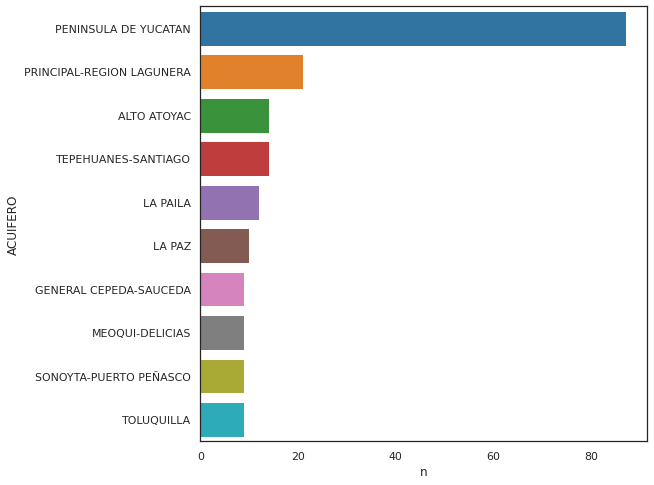

Valores únicos:
(Sólo los primeros 10 valores)
+---------------------------+------------+
|                           |   ACUIFERO |
|---------------------------+------------|
| PENINSULA DE YUCATAN      |         87 |
| PRINCIPAL-REGION LAGUNERA |         21 |
| ALTO ATOYAC               |         14 |
| TEPEHUANES-SANTIAGO       |         14 |
| LA PAILA                  |         12 |
| LA PAZ                    |         10 |
| GENERAL CEPEDA-SAUCEDA    |          9 |
| MEOQUI-DELICIAS           |          9 |
| SONOYTA-PUERTO PEÑASCO    |          9 |
| TOLUQUILLA                |          9 |
+---------------------------+------------+


In [11]:
analizar_variable({
    'column': 'ACUIFERO',
    'dict_key': 'ACUIFERO',
    'type': 'category',
})

### Organismo de Cuenca


    -----------------------------------------
    Variable: ORGANISMO_DE_CUENCA
    -----------------------------------------
    Descripcion: Nombre del Organismo de Cuenca de agua donde se localiza el sitio de monitoreo
    Tipo: category
    Nulos: 0
    
(Sólo los primeros 10 valores)


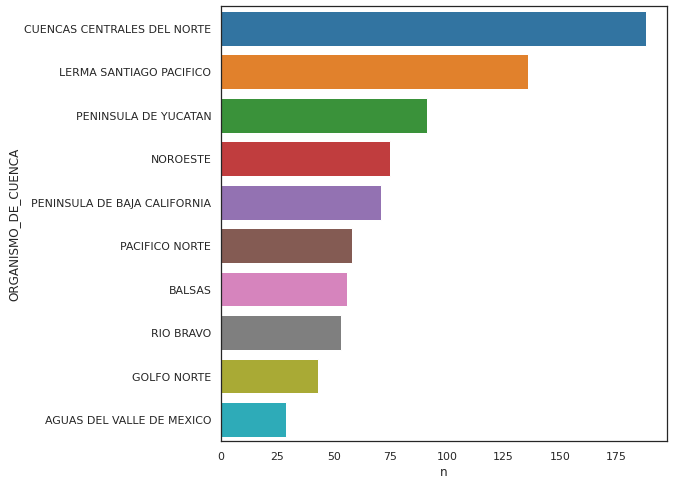

Valores únicos:
(Sólo los primeros 10 valores)
+------------------------------+-----------------------+
|                              |   ORGANISMO_DE_CUENCA |
|------------------------------+-----------------------|
| CUENCAS CENTRALES DEL NORTE  |                   188 |
| LERMA SANTIAGO PACIFICO      |                   136 |
| PENINSULA DE YUCATAN         |                    91 |
| NOROESTE                     |                    75 |
| PENINSULA DE BAJA CALIFORNIA |                    71 |
| PACIFICO NORTE               |                    58 |
| BALSAS                       |                    56 |
| RIO BRAVO                    |                    53 |
| GOLFO NORTE                  |                    43 |
| AGUAS DEL VALLE DE MEXICO    |                    29 |
+------------------------------+-----------------------+


In [12]:
analizar_variable({
    'column': 'ORGANISMO_DE_CUENCA',
    'dict_key': 'NOMBRE_ORGANISMO_DE_CUENCA',
    'type': 'category',
})

### Subtipo


    -----------------------------------------
    Variable: SUBTIPO
    -----------------------------------------
    Descripcion: Descripción no encontrada en diccionario.
    Tipo: category
    Nulos: 0
    
(Sólo los primeros 10 valores)


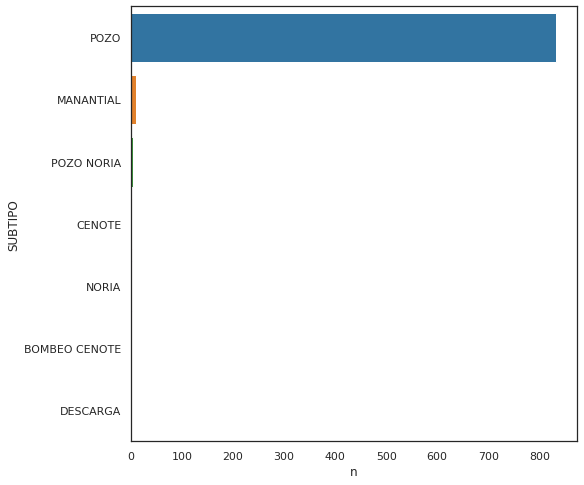

Valores únicos:
(Sólo los primeros 10 valores)
+---------------+-----------+
|               |   SUBTIPO |
|---------------+-----------|
| POZO          |       833 |
| MANANTIAL     |        10 |
| POZO NORIA    |         4 |
| CENOTE        |         3 |
| NORIA         |         2 |
| BOMBEO CENOTE |         1 |
| DESCARGA      |         1 |
+---------------+-----------+


In [13]:
analizar_variable({
    'column': 'SUBTIPO',
    'type': 'category',
})

## Contaminantes

### Alcalinidad


    -----------------------------------------
    Variable: ALC_mg/L
    -----------------------------------------
    Descripcion: Valor de Alcalinidad Total, en miligramos por litro
    Tipo: number
    Nulos: 4
    


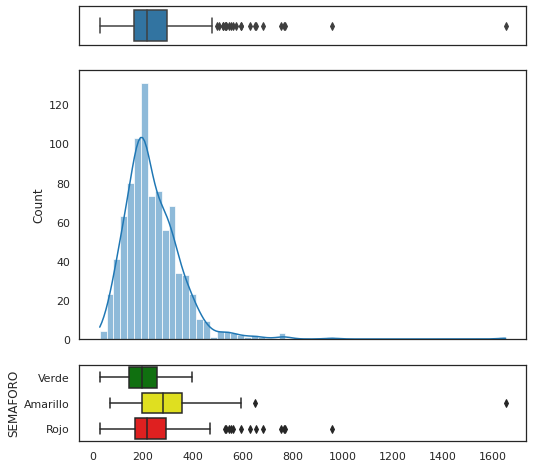

+----------+---------+---------+----------+-------+---------+--------+---------+--------+
|          |   count |    mean |      std |   min |     25% |    50% |     75% |    max |
|----------+---------+---------+----------+-------+---------+--------+---------+--------|
| ALC_mg/L |     850 | 236.897 | 117.823  | 26.64 | 164.46  | 214.81 | 297     | 1650   |
| Verde    |     335 | 200.11  |  78.5658 | 28.86 | 143.975 | 193.87 | 257.555 |  397.1 |
| Amarillo |     198 | 287.74  | 144.932  | 66.6  | 197.58  | 280.4  | 355.265 | 1650   |
| Rojo     |     317 | 244.017 | 120.719  | 26.64 | 168.72  | 215    | 291.28  |  954.6 |
+----------+---------+---------+----------+-------+---------+--------+---------+--------+


In [14]:
analizar_variable({
    'column': 'ALC_mg/L',
    'dict_key': 'ALC_mg/L',
    'type': 'number',
})


    -----------------------------------------
    Variable: CUMPLE_CON_ALC
    -----------------------------------------
    Descripcion: Indica si cumple con la calidad de Baja, Media, o Alta para el Indicador Alcalinidad Total
    Tipo: classification
    Nulos: 0
    


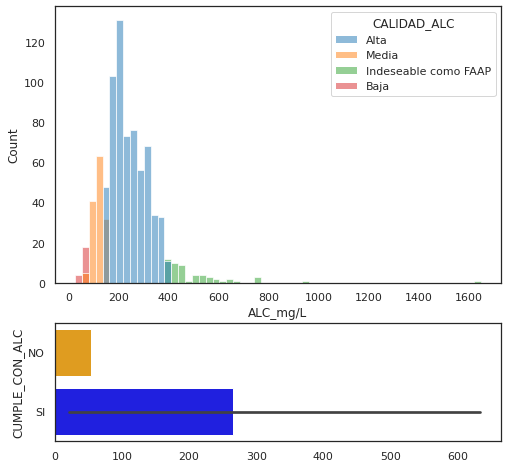

+----+----------------------+----------+---------+----------+---------+
|    | calidad              | cumple   |     min |     mean |     max |
|----+----------------------+----------+---------+----------+---------|
|  0 | Baja                 | SI       |  26.64  |  60.3543 |   73.26 |
|  1 | Media                | SI       |  75.555 | 118.592  |  150    |
|  2 | Alta                 | SI       | 150.015 | 245.036  |  399.6  |
|  3 | Indeseable como FAAP | NO       | 400.77  | 522.326  | 1650    |
+----+----------------------+----------+---------+----------+---------+


In [15]:
analizar_variable({
    'column': 'CUMPLE_CON_ALC',
    'dict_key': 'CUMPLE_CON_ALC',
    'type': 'classification',
    'classification_dict': {'value': 'ALC_mg/L', 'class': 'CALIDAD_ALC'}
})

### Arsenico


    -----------------------------------------
    Variable: AS_TOT_mg/L
    -----------------------------------------
    Descripcion: Valor de Arsenico Total, en miligramos por litro 
    Tipo: pseudonumber
    Nulos: 652
    


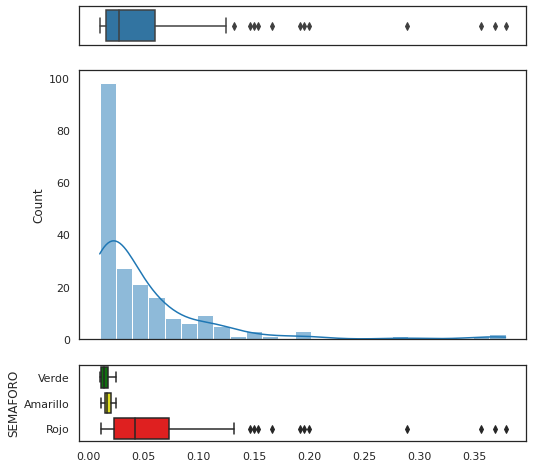

+-------------+---------+-----------+------------+--------+----------+---------+----------+--------+
|             |   count |      mean |        std |    min |      25% |     50% |      75% |    max |
|-------------+---------+-----------+------------+--------+----------+---------+----------+--------|
| AS_TOT_mg/L |     202 | 0.0490461 | 0.0578477  | 0.01   | 0.0158   | 0.02725 | 0.0605   | 0.3784 |
| Verde       |      40 | 0.0147012 | 0.00408362 | 0.01   | 0.011175 | 0.01395 | 0.017075 | 0.0246 |
| Amarillo    |      16 | 0.0173006 | 0.00425717 | 0.0107 | 0.014575 | 0.0166  | 0.020525 | 0.025  |
| Rojo        |     146 | 0.0619346 | 0.0634707  | 0.0108 | 0.023375 | 0.0423  | 0.07265  | 0.3784 |
+-------------+---------+-----------+------------+--------+----------+---------+----------+--------+


In [16]:
analizar_variable({
    'column': 'AS_TOT_mg/L',
    'dict_key': 'AS_TOT_mg/L',
    'type': 'pseudonumber',
})


    -----------------------------------------
    Variable: CUMPLE_CON_AS
    -----------------------------------------
    Descripcion: Indica si cumple con la calidad de Potable - Excelente o Apta como FAAP, para el Indicador Arsenico Total 
    Tipo: classification
    Nulos: 0
    


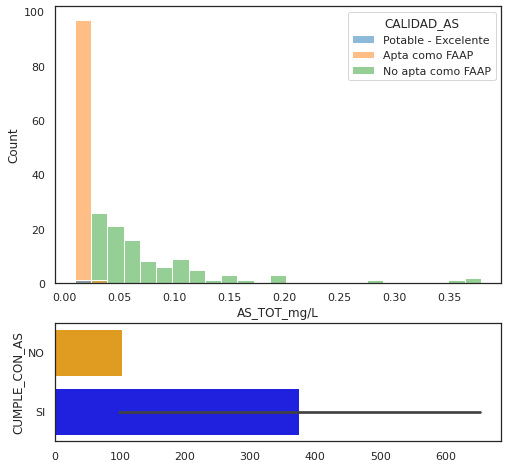

+----+---------------------+----------+--------+-------------+--------+
|    | calidad             | cumple   |    min |        mean |    max |
|----+---------------------+----------+--------+-------------+--------|
|  0 | Potable - Excelente | SI       | 0      | 1.53139e-05 | 0.01   |
|  1 | Apta como FAAP      | SI       | 0.0101 | 0.0165511   | 0.025  |
|  2 | No apta como FAAP   | NO       | 0.0252 | 0.0803427   | 0.3784 |
+----+---------------------+----------+--------+-------------+--------+


In [17]:
analizar_variable({
    'column': 'CUMPLE_CON_AS',
    'dict_key': 'CUMPLE_CON_AS',
    'type': 'classification',
    'classification_dict': {'value': 'AS_TOT_mg/L', 'class': 'CALIDAD_AS'}
})

### Coliformes Fecales


    -----------------------------------------
    Variable: COLI_FEC_NMP/100_mL
    -----------------------------------------
    Descripcion: Valor de Coliformes Fecales, en Numero Mas Probable por 100 mililitros
    Tipo: pseudonumber
    Nulos: 585
    


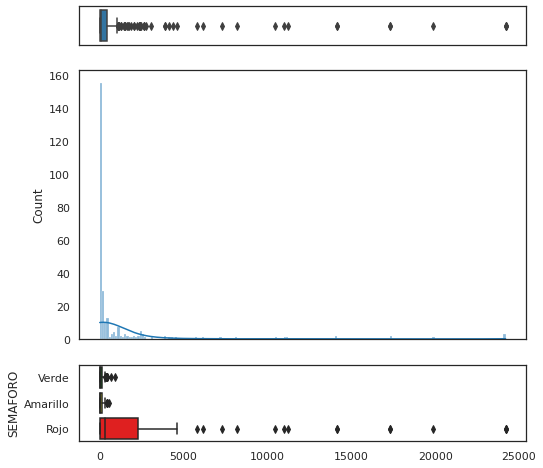

+---------------------+---------+----------+----------+-------+-------+-------+---------+-------+
|                     |   count |     mean |      std |   min |   25% |   50% |     75% |   max |
|---------------------+---------+----------+----------+-------+-------+-------+---------+-------|
| COLI_FEC_NMP/100_mL |     269 | 1208.99  | 3627.92  |     3 | 20    |  90   |  448    | 24196 |
| Verde               |      81 |  118.136 |  161.207 |     3 | 20    |  41   |  146    |   908 |
| Amarillo            |      60 |  108.583 |  144.806 |     4 | 10.75 |  40   |  152.25 |   530 |
| Rojo                |     128 | 2415.11  | 4995.12  |     4 | 40    | 332.5 | 2275    | 24196 |
+---------------------+---------+----------+----------+-------+-------+-------+---------+-------+


In [18]:
analizar_variable({
    'column': 'COLI_FEC_NMP/100_mL',
    'dict_key': 'COLI_FEC_NMP/100_mL',
    'type': 'pseudonumber',
})


    -----------------------------------------
    Variable: CUMPLE_CON_CF
    -----------------------------------------
    Descripcion: Indica si cumple con la calidad de Potable - Excelente, o Buena calidad, Aceptable, para el Indicador Coliformes Fecales
    Tipo: classification
    Nulos: 0
    


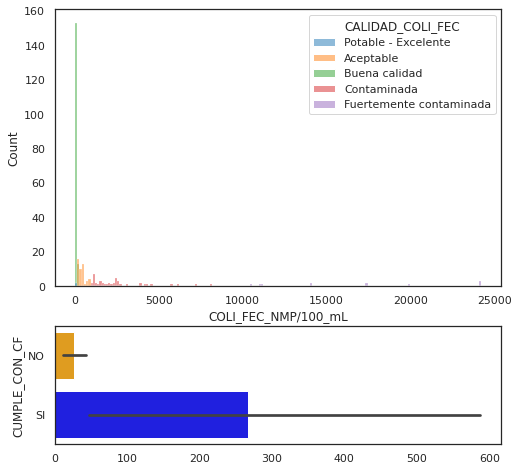

+----+-------------------------+----------+-------+---------------+-------+
|    | calidad                 | cumple   |   min |          mean |   max |
|----+-------------------------+----------+-------+---------------+-------|
|  0 | Potable - Excelente     | SI       |     0 |     0.0102215 |     3 |
|  1 | Buena calidad           | SI       |     4 |    48.5181    |   200 |
|  2 | Aceptable               | SI       |   201 |   404.043     |   908 |
|  3 | Contaminada             | NO       |  1017 |  2561.07      |  8161 |
|  4 | Fuertemente contaminada | NO       | 10462 | 17094.7       | 24196 |
+----+-------------------------+----------+-------+---------------+-------+


In [19]:
analizar_variable({
    'column': 'CUMPLE_CON_CF',
    'dict_key': 'CUMPLE_CON_CF',
    'type': 'classification',
    'classification_dict': {'value': 'COLI_FEC_NMP/100_mL', 'class': 'CALIDAD_COLI_FEC'}
})

### Conductividad


    -----------------------------------------
    Variable: CONDUCT_mS/cm
    -----------------------------------------
    Descripcion: Valor de Conductividad en microSiemens por centimetro
    Tipo: pseudonumber
    Nulos: 5
    


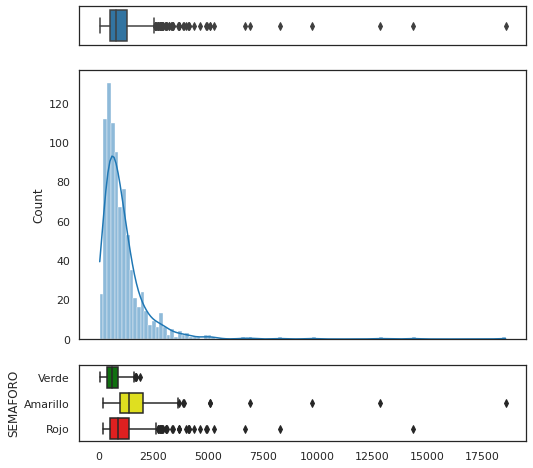

+---------------+---------+----------+----------+-------+--------+--------+---------+-------+
|               |   count |     mean |      std |   min |    25% |    50% |     75% |   max |
|---------------+---------+----------+----------+-------+--------+--------+---------+-------|
| CONDUCT_mS/cm |     849 | 1123.7   | 1270.56  |  50.4 | 499    |  810   | 1309    | 18577 |
| Verde         |     334 |  660.463 |  349.811 |  50.4 | 391.75 |  597.5 |  881    |  1896 |
| Amarillo      |     198 | 1727.33  | 1828.09  | 221   | 968    | 1371.5 | 2030.25 | 18577 |
| Rojo          |     317 | 1234.76  | 1285.4   | 210   | 541    |  872   | 1400    | 14350 |
+---------------+---------+----------+----------+-------+--------+--------+---------+-------+


In [20]:
analizar_variable({
    'column': 'CONDUCT_mS/cm',
    'dict_key': 'CONDUCT_mS/cm',
    'type': 'pseudonumber',
})


    -----------------------------------------
    Variable: CUMPLE_CON_COND
    -----------------------------------------
    Descripcion: Indica si cumple con la calidad de Excelente para riego, Buena para riego, o Permisible para riego, para el Indicador Conductividad
    Tipo: classification
    Nulos: 0
    


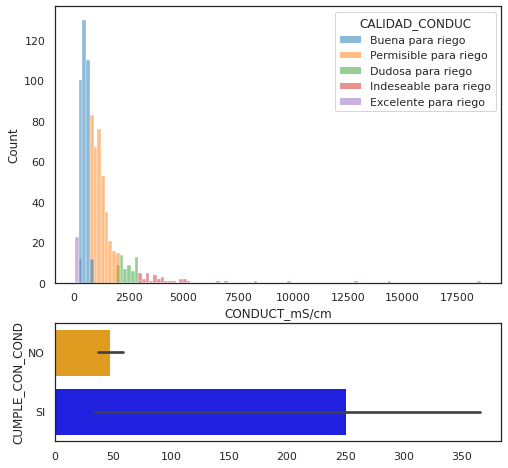

+----+-----------------------+----------+--------+----------+-------+
|    | calidad               | cumple   |    min |     mean |   max |
|----+-----------------------+----------+--------+----------+-------|
|  0 | Excelente para riego  | SI       |   50.4 |  187.52  |   245 |
|  1 | Buena para riego      | SI       |  252   |  491.585 |   749 |
|  2 | Permisible para riego | SI       |  751   | 1195.45  |  1998 |
|  3 | Dudosa para riego     | NO       | 2004   | 2444.38  |  2957 |
|  4 | Indeseable para riego | NO       | 3045   | 5207.34  | 18577 |
+----+-----------------------+----------+--------+----------+-------+


In [21]:
analizar_variable({
    'column': 'CUMPLE_CON_COND',
    'dict_key': 'CUMPLE_CON_COND',
    'type': 'classification',
    'classification_dict': {'value': 'CONDUCT_mS/cm', 'class': 'CALIDAD_CONDUC'}
})

### Cadmio


    -----------------------------------------
    Variable: CD_TOT_mg/L
    -----------------------------------------
    Descripcion: Valor de Cadmio Total, en miligramos por litro
    Tipo: pseudonumber
    Nulos: 854
    


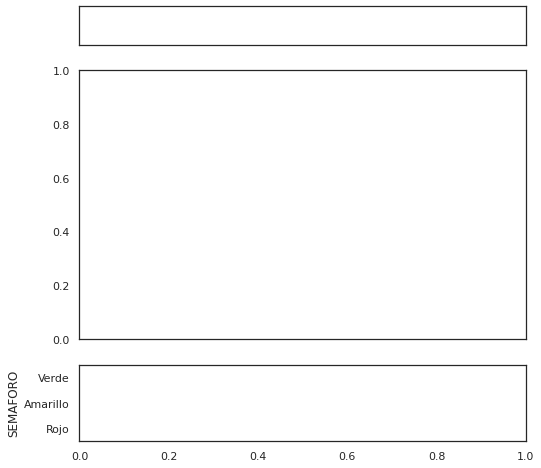

+-------------+---------+--------+-------+-------+-------+-------+-------+-------+
|             |   count |   mean |   std |   min |   25% |   50% |   75% |   max |
|-------------+---------+--------+-------+-------+-------+-------+-------+-------|
| CD_TOT_mg/L |       0 |    nan |   nan |   nan |   nan |   nan |   nan |   nan |
| Verde       |       0 |    nan |   nan |   nan |   nan |   nan |   nan |   nan |
| Amarillo    |       0 |    nan |   nan |   nan |   nan |   nan |   nan |   nan |
| Rojo        |       0 |    nan |   nan |   nan |   nan |   nan |   nan |   nan |
+-------------+---------+--------+-------+-------+-------+-------+-------+-------+


In [22]:
analizar_variable({
    'column': 'CD_TOT_mg/L',
    'dict_key': 'CD_TOT_mg/L',
    'type': 'pseudonumber',
})


    -----------------------------------------
    Variable: CUMPLE_CON_CD
    -----------------------------------------
    Descripcion: Indica si cumple con la calidad de Potable - Excelente, para el Indicador Cadmio Total
    Tipo: classification
    Nulos: 0
    


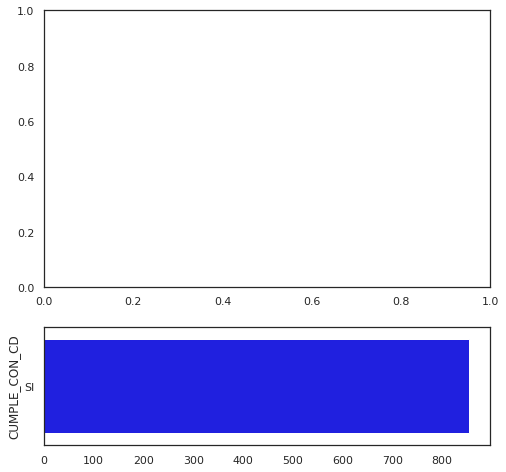

+----+---------------------+----------+-------+--------+-------+
|    | calidad             | cumple   |   min |   mean |   max |
|----+---------------------+----------+-------+--------+-------|
|  0 | Potable - Excelente | SI       |     0 |      0 |     0 |
+----+---------------------+----------+-------+--------+-------+


In [23]:
analizar_variable({
    'column': 'CUMPLE_CON_CD',
    'dict_key': 'CUMPLE_CON_CD',
    'type': 'classification',
    'classification_dict': {'value': 'CD_TOT_mg/L', 'class': 'CALIDAD_CD'}
})

### Cromo


    -----------------------------------------
    Variable: CR_TOT_mg/L
    -----------------------------------------
    Descripcion: Valor de Cromo Total, en miligramos por litro
    Tipo: pseudonumber
    Nulos: 689
    


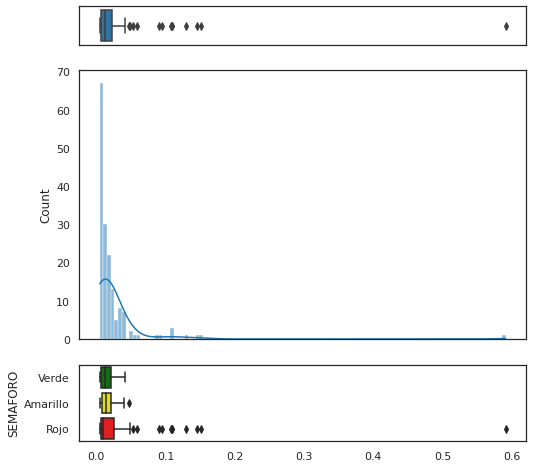

+-------------+---------+-----------+-----------+-------+-----------+----------+-----------+---------+
|             |   count |      mean |       std |   min |       25% |      50% |       75% |     max |
|-------------+---------+-----------+-----------+-------+-----------+----------+-----------+---------|
| CR_TOT_mg/L |     165 | 0.0240813 | 0.0509332 | 0.005 | 0.0074    | 0.01236  | 0.02201   | 0.591   |
| Verde       |      68 | 0.0162743 | 0.0107556 | 0.005 | 0.0074075 | 0.01299  | 0.0217725 | 0.042   |
| Amarillo    |      32 | 0.0174234 | 0.0116056 | 0.005 | 0.008925  | 0.013745 | 0.02195   | 0.04792 |
| Rojo        |      65 | 0.0355265 | 0.0790019 | 0.005 | 0.0071    | 0.0099   | 0.02508   | 0.591   |
+-------------+---------+-----------+-----------+-------+-----------+----------+-----------+---------+


In [24]:
analizar_variable({
    'column': 'CR_TOT_mg/L',
    'dict_key': 'CR_TOT_mg/L',
    'type': 'pseudonumber',
})


    -----------------------------------------
    Variable: CUMPLE_CON_CR
    -----------------------------------------
    Descripcion: Indica si cumple con la calidad de Potable - Excelente, para el Indicador Cromo Total
    Tipo: classification
    Nulos: 0
    


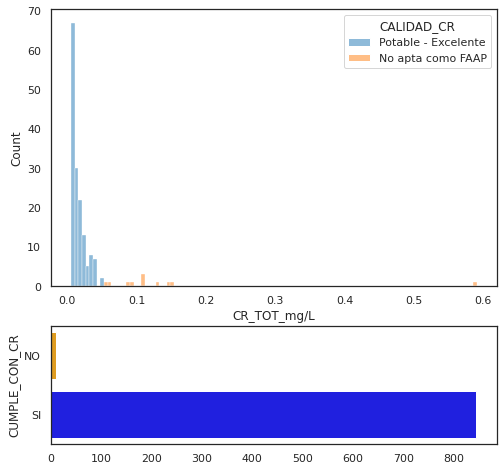

+----+---------------------+----------+--------+-----------+---------+
|    | calidad             | cumple   |    min |      mean |     max |
|----+---------------------+----------+--------+-----------+---------|
|  0 | Potable - Excelente | SI       | 0      | 0.0027658 | 0.04821 |
|  1 | No apta como FAAP   | NO       | 0.0533 | 0.149259  | 0.591   |
+----+---------------------+----------+--------+-----------+---------+


In [25]:
analizar_variable({
    'column': 'CUMPLE_CON_CR',
    'dict_key': 'CUMPLE_CON_CR',
    'type': 'classification',
    'classification_dict': {'value': 'CR_TOT_mg/L', 'class': 'CALIDAD_CR'}
})

### Dureza


    -----------------------------------------
    Variable: DUR_mg/L
    -----------------------------------------
    Descripcion: Valor de Dureza Total, en miligramos por litro
    Tipo: pseudonumber
    Nulos: 18
    


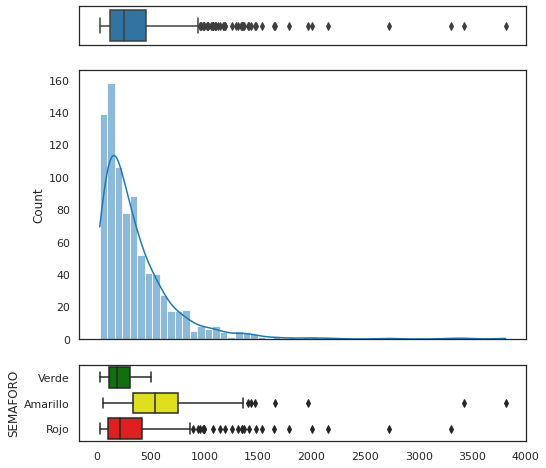

+----------+---------+---------+---------+---------+---------+---------+---------+---------+
|          |   count |    mean |     std |     min |     25% |     50% |     75% |     max |
|----------+---------+---------+---------+---------+---------+---------+---------+---------|
| DUR_mg/L |     836 | 352.993 | 371.603 | 23.68   | 123.306 | 245.662 | 456.016 | 3810.69 |
| Verde    |     334 | 212.187 | 122.773 | 23.68   | 114.56  | 185.526 | 306.576 |  498    |
| Amarillo |     197 | 601.297 | 455.479 | 51      | 338     | 542.958 | 757.86  | 3810.69 |
| Rojo     |     305 | 346.806 | 408.957 | 24.8725 | 101.592 | 210     | 415.785 | 3302.4  |
+----------+---------+---------+---------+---------+---------+---------+---------+---------+


In [26]:
analizar_variable({
    'column': 'DUR_mg/L',
    'dict_key': 'DUR_mg/L',
    'type': 'pseudonumber',
})


    -----------------------------------------
    Variable: CUMPLE_CON_DUR
    -----------------------------------------
    Descripcion: Indica si cumple con la calidad de Potable - Suave, Potable - Moderadamente suave, o Potable - Dura, para el Indicador Dureza Total
    Tipo: classification
    Nulos: 0
    


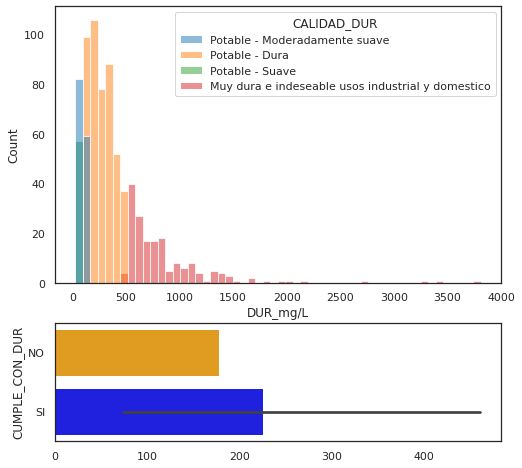

+----+---------------------------------------------------+----------+---------+----------+----------+
|    | calidad                                           | cumple   |     min |     mean |      max |
|----+---------------------------------------------------+----------+---------+----------+----------|
|  0 | Potable - Suave                                   | SI       |   0     |  34.0873 |   59.838 |
|  1 | Potable - Moderadamente suave                     | SI       |  60.576 |  90.7422 |  120     |
|  2 | Potable - Dura                                    | SI       | 120.39  | 269.553  |  498     |
|  3 | Muy dura e indeseable usos industrial y domestico | NO       | 501.29  | 875.226  | 3810.69  |
+----+---------------------------------------------------+----------+---------+----------+----------+


In [27]:
analizar_variable({
    'column': 'CUMPLE_CON_DUR',
    'dict_key': 'CUMPLE_CON_DUR',
    'type': 'classification',
    'classification_dict': {'value': 'DUR_mg/L', 'class': 'CALIDAD_DUR'}
})

### Fluoruros


    -----------------------------------------
    Variable: FLUORUROS_mg/L
    -----------------------------------------
    Descripcion: Valor de Fluoruros Totales (F-), en miligramos por litro
    Tipo: pseudonumber
    Nulos: 123
    


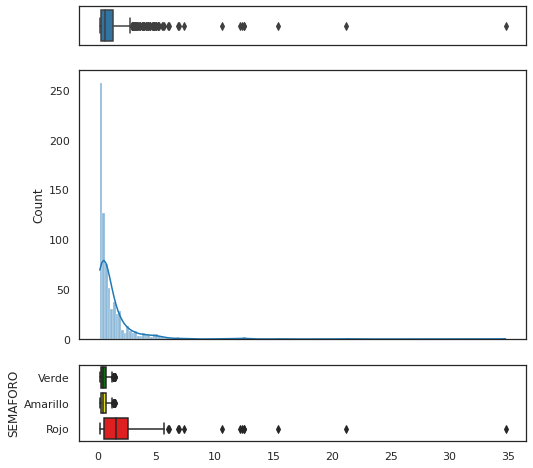

+----------------+---------+----------+----------+--------+----------+---------+---------+---------+
|                |   count |     mean |      std |    min |      25% |     50% |     75% |     max |
|----------------+---------+----------+----------+--------+----------+---------+---------+---------|
| FLUORUROS_mg/L |     731 | 1.23718  | 2.12993  | 0.2008 | 0.34685  | 0.6076  | 1.37045 | 34.8033 |
| Verde          |     277 | 0.560361 | 0.33344  | 0.2035 | 0.299    | 0.448   | 0.7108  |  1.4964 |
| Amarillo       |     154 | 0.544848 | 0.324675 | 0.2008 | 0.306375 | 0.44665 | 0.70035 |  1.4876 |
| Rojo           |     300 | 2.2175   | 3.04695  | 0.2054 | 0.568575 | 1.59755 | 2.6484  | 34.8033 |
+----------------+---------+----------+----------+--------+----------+---------+---------+---------+


In [28]:
analizar_variable({
    'column': 'FLUORUROS_mg/L',
    'dict_key': 'FLUORUROS_mg/L',
    'type': 'pseudonumber',
})


    -----------------------------------------
    Variable: CUMPLE_CON_FLUO
    -----------------------------------------
    Descripcion: Indica si cumple con la calidad de Baja, Media, o Potable - Optima, para el Indicador Fluoruros Totales
    Tipo: classification
    Nulos: 0
    


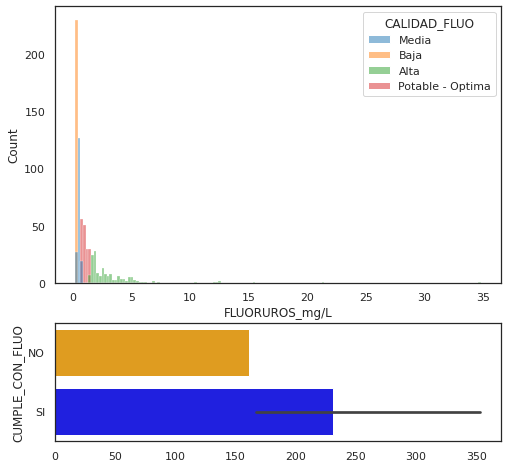

+----+------------------+----------+--------+----------+---------+
|    | calidad          | cumple   |    min |     mean |     max |
|----+------------------+----------+--------+----------+---------|
|  0 | Baja             | SI       | 0      | 0.18991  |  0.3991 |
|  1 | Media            | SI       | 0.4    | 0.522758 |  0.699  |
|  2 | Potable - Optima | SI       | 0.7001 | 1.03268  |  1.4964 |
|  3 | Alta             | NO       | 1.5103 | 3.56797  | 34.8033 |
+----+------------------+----------+--------+----------+---------+


In [29]:
analizar_variable({
    'column': 'CUMPLE_CON_FLUO',
    'dict_key': 'CUMPLE_CON_FLUO',
    'type': 'classification',
    'classification_dict': {'value': 'FLUORUROS_mg/L', 'class': 'CALIDAD_FLUO'}
})

### Hierro


    -----------------------------------------
    Variable: FE_TOT_mg/L
    -----------------------------------------
    Descripcion: Valor de Hierro Total, en miligramos por litro
    Tipo: pseudonumber
    Nulos: 323
    


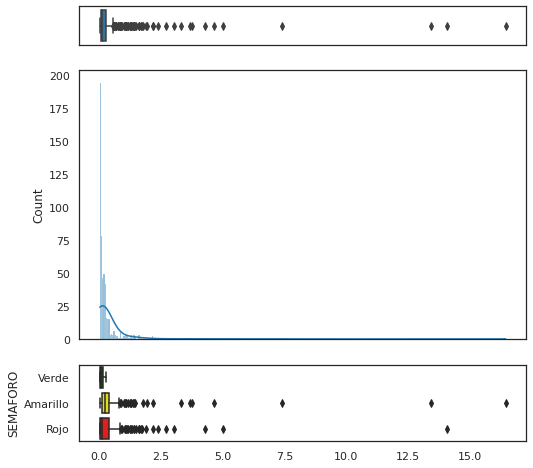

+-------------+---------+----------+-----------+---------+-----------+---------+----------+---------+
|             |   count |     mean |       std |     min |       25% |     50% |      75% |     max |
|-------------+---------+----------+-----------+---------+-----------+---------+----------+---------|
| FE_TOT_mg/L |     531 | 0.394992 | 1.25898   | 0.0253  | 0.05605   | 0.1165  | 0.26053  | 16.4371 |
| Verde       |     177 | 0.106048 | 0.0758464 | 0.0253  | 0.0465    | 0.07547 | 0.1661   |  0.2901 |
| Amarillo    |     166 | 0.632596 | 1.80782   | 0.02701 | 0.0983775 | 0.2288  | 0.39305  | 16.4371 |
| Rojo        |     188 | 0.45723  | 1.21251   | 0.0253  | 0.052475  | 0.10047 | 0.385027 | 14.06   |
+-------------+---------+----------+-----------+---------+-----------+---------+----------+---------+


In [30]:
analizar_variable({
    'column': 'FE_TOT_mg/L',
    'dict_key': 'FE_TOT_mg/L',
    'type': 'pseudonumber',
})


    -----------------------------------------
    Variable: CUMPLE_CON_FE
    -----------------------------------------
    Descripcion: Indica si cumple con la calidad de Potable - Excelente, para el Indicador Hierro Total
    Tipo: classification
    Nulos: 0
    


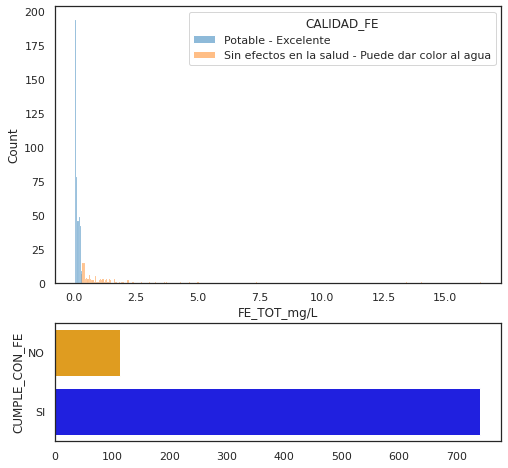

+----+---------------------------------------------------+----------+--------+-----------+---------+
|    | calidad                                           | cumple   |    min |      mean |     max |
|----+---------------------------------------------------+----------+--------+-----------+---------|
|  0 | Potable - Excelente                               | SI       | 0      | 0.0625434 |  0.2983 |
|  1 | Sin efectos en la salud - Puede dar color al agua | NO       | 0.3001 | 1.44598   | 16.4371 |
+----+---------------------------------------------------+----------+--------+-----------+---------+


In [31]:
analizar_variable({
    'column': 'CUMPLE_CON_FE',
    'dict_key': 'CUMPLE_CON_FE',
    'type': 'classification',
    'classification_dict': {'value': 'FE_TOT_mg/L', 'class': 'CALIDAD_FE'}
})

### Manganesio


    -----------------------------------------
    Variable: MN_TOT_mg/L
    -----------------------------------------
    Descripcion: Valor de Manganeso Total, en miligramos por litro
    Tipo: pseudonumber
    Nulos: 436
    


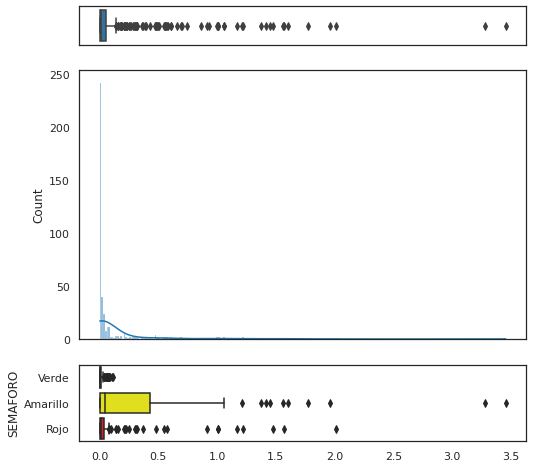

+-------------+---------+-----------+----------+--------+----------+----------+----------+--------+
|             |   count |      mean |      std |    min |      25% |      50% |      75% |    max |
|-------------+---------+-----------+----------+--------+----------+----------+----------+--------|
| MN_TOT_mg/L |     418 | 0.144482  | 0.387391 | 0.0015 | 0.003625 | 0.01082  | 0.05813  | 3.4548 |
| Verde       |     131 | 0.0152613 | 0.022728 | 0.0015 | 0.0029   | 0.0056   | 0.01525  | 0.1165 |
| Amarillo    |     129 | 0.322383  | 0.570972 | 0.0015 | 0.0078   | 0.0497   | 0.4308   | 3.4548 |
| Rojo        |     158 | 0.106372  | 0.301629 | 0.0015 | 0.003825 | 0.010965 | 0.034725 | 2.015  |
+-------------+---------+-----------+----------+--------+----------+----------+----------+--------+


In [32]:
analizar_variable({
    'column': 'MN_TOT_mg/L',
    'dict_key': 'MN_TOT_mg/L',
    'type': 'pseudonumber',
})


    -----------------------------------------
    Variable: CUMPLE_CON_MN
    -----------------------------------------
    Descripcion: Indica si cumple con la calidad de Potable - Excelente, para el Indicador Manganeso Total
    Tipo: classification
    Nulos: 0
    


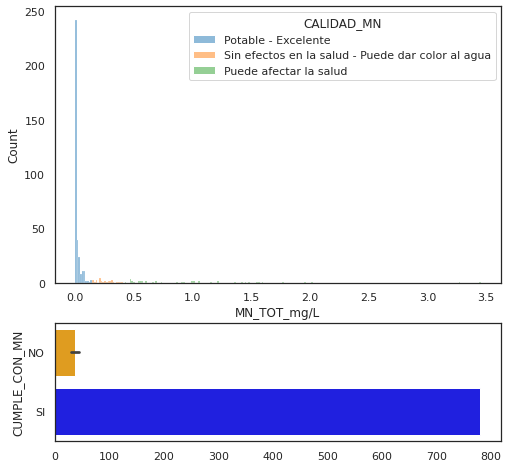

+----+---------------------------------------------------+----------+--------+------------+---------+
|    | calidad                                           | cumple   |    min |       mean |     max |
|----+---------------------------------------------------+----------+--------+------------+---------|
|  0 | Potable - Excelente                               | SI       | 0      | 0.00780556 | 0.14319 |
|  1 | Sin efectos en la salud - Puede dar color al agua | NO       | 0.1564 | 0.256628   | 0.398   |
|  2 | Puede afectar la salud                            | NO       | 0.4308 | 1.05923    | 3.4548  |
+----+---------------------------------------------------+----------+--------+------------+---------+


In [33]:
analizar_variable({
    'column': 'CUMPLE_CON_MN',
    'dict_key': 'CUMPLE_CON_MN',
    'type': 'classification',
    'classification_dict': {'value': 'MN_TOT_mg/L', 'class': 'CALIDAD_MN'}
})

### Mercurio


    -----------------------------------------
    Variable: HG_TOT_mg/L
    -----------------------------------------
    Descripcion: Valor de Mercurio Total, en miligramos por litro
    Tipo: pseudonumber
    Nulos: 775
    


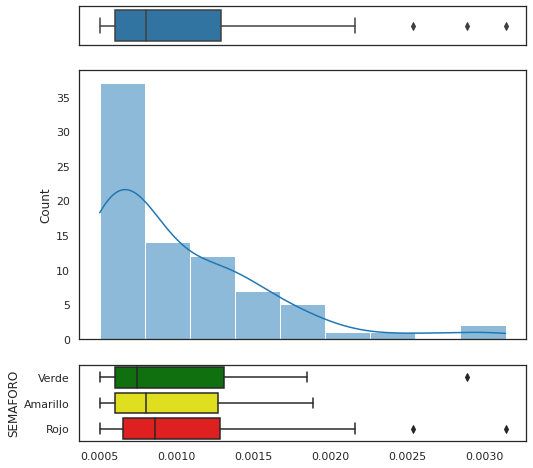

+-------------+---------+-------------+-------------+--------+---------+---------+---------+---------+
|             |   count |        mean |         std |    min |     25% |     50% |     75% |     max |
|-------------+---------+-------------+-------------+--------+---------+---------+---------+---------|
| HG_TOT_mg/L |      79 | 0.00101051  | 0.000556034 | 0.0005 | 0.0006  | 0.0008  | 0.00129 | 0.00314 |
| Verde       |      33 | 0.000982424 | 0.000547631 | 0.0005 | 0.0006  | 0.00074 | 0.00131 | 0.00289 |
| Amarillo    |      21 | 0.000954286 | 0.000434552 | 0.0005 | 0.0006  | 0.0008  | 0.00127 | 0.00189 |
| Rojo        |      25 | 0.0010948   | 0.000660556 | 0.0005 | 0.00065 | 0.00086 | 0.00128 | 0.00314 |
+-------------+---------+-------------+-------------+--------+---------+---------+---------+---------+


In [34]:
analizar_variable({
    'column': 'HG_TOT_mg/L',
    'dict_key': 'HG_TOT_mg/L',
    'type': 'pseudonumber',
})


    -----------------------------------------
    Variable: CUMPLE_CON_HG
    -----------------------------------------
    Descripcion: Indica si cumple con la calidad de Potable - Excelente, para el Indicador Mercurio Total
    Tipo: classification
    Nulos: 0
    


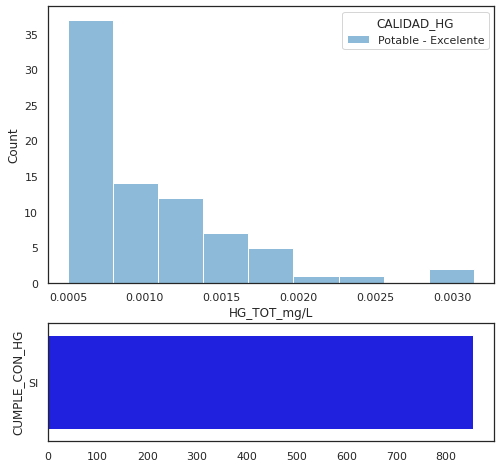

+----+---------------------+----------+-------+-------------+---------+
|    | calidad             | cumple   |   min |        mean |     max |
|----+---------------------+----------+-------+-------------+---------|
|  0 | Potable - Excelente | SI       |     0 | 9.34778e-05 | 0.00314 |
+----+---------------------+----------+-------+-------------+---------+


In [35]:
analizar_variable({
    'column': 'CUMPLE_CON_HG',
    'dict_key': 'CUMPLE_CON_HG',
    'type': 'classification',
    'classification_dict': {'value': 'HG_TOT_mg/L', 'class': 'CALIDAD_HG'}
})

### Nitrogeno de Nitratos


    -----------------------------------------
    Variable: N_NO3_mg/L
    -----------------------------------------
    Descripcion: Valor de Nitrogeno de Nitratos, en miligramos por litro
    Tipo: pseudonumber
    Nulos: 60
    


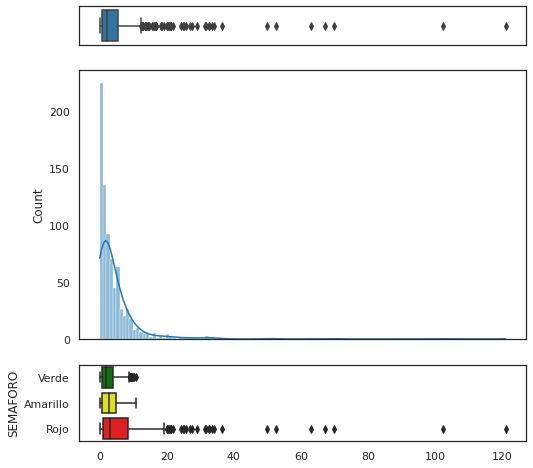

+------------+---------+---------+----------+----------+----------+---------+---------+----------+
|            |   count |    mean |      std |      min |      25% |     50% |     75% |      max |
|------------+---------+---------+----------+----------+----------+---------+---------+----------|
| N_NO3_mg/L |     794 | 4.66861 |  8.74979 | 0.0208   | 0.829748 | 2.23125 | 5.4188  | 121.008  |
| Verde      |     320 | 2.77886 |  2.65995 | 0.0208   | 0.704455 | 1.93486 | 3.96287 |  10.7466 |
| Amarillo   |     170 | 3.10038 |  2.65744 | 0.022059 | 0.752898 | 2.63324 | 4.89812 |  10.8918 |
| Rojo       |     304 | 7.5348  | 13.2509  | 0.021    | 1.08929  | 3.09737 | 8.38588 | 121.008  |
+------------+---------+---------+----------+----------+----------+---------+---------+----------+


In [36]:
analizar_variable({
    'column': 'N_NO3_mg/L',
    'dict_key': 'N_NO3_mg/L',
    'type': 'pseudonumber',
})


    -----------------------------------------
    Variable: CUMPLE_CON_NO3
    -----------------------------------------
    Descripcion: Indica si cumple con la calidad de Potable - Excelente o Potable - Buena calidad, para el Indicador Nitrogeno de Nitratos
    Tipo: classification
    Nulos: 0
    


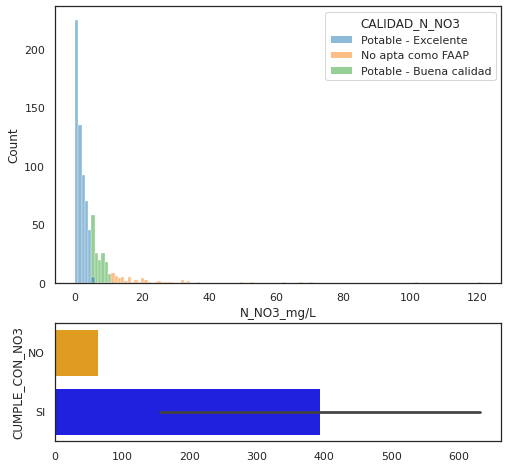

+----+-------------------------+----------+---------+----------+-----------+
|    | calidad                 | cumple   |     min |     mean |       max |
|----+-------------------------+----------+---------+----------+-----------|
|  0 | Potable - Excelente     | SI       |  0      |  1.56096 |   4.99221 |
|  1 | Potable - Buena calidad | SI       |  5.022  |  7.0744  |  10.8918  |
|  2 | No apta como FAAP       | NO       | 11.0041 | 24.7881  | 121.008   |
+----+-------------------------+----------+---------+----------+-----------+


In [37]:
analizar_variable({
    'column': 'CUMPLE_CON_NO3',
    'dict_key': 'CUMPLE_CON_NO3',
    'type': 'classification',
    'classification_dict': {'value': 'N_NO3_mg/L', 'class': 'CALIDAD_N_NO3'}
})

### Plomo


    -----------------------------------------
    Variable: PB_TOT_mg/L
    -----------------------------------------
    Descripcion: Valor de Plomo Total, en miligramos por litro
    Tipo: pseudonumber
    Nulos: 830
    


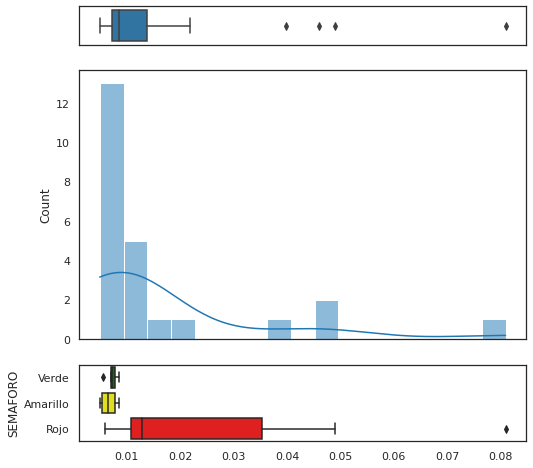

+-------------+---------+------------+------------+---------+-----------+----------+-----------+---------+
|             |   count |       mean |        std |     min |       25% |      50% |       75% |     max |
|-------------+---------+------------+------------+---------+-----------+----------+-----------+---------|
| PB_TOT_mg/L |      24 | 0.0168142  | 0.0185861  | 0.005   | 0.0072775 | 0.008595 | 0.013925  | 0.0809  |
| Verde       |       6 | 0.00733667 | 0.00104422 | 0.00556 | 0.0071075 | 0.007355 | 0.00794   | 0.00859 |
| Amarillo    |       4 | 0.006715   | 0.00170842 | 0.005   | 0.0054275 | 0.00663  | 0.0079175 | 0.0086  |
| Rojo        |      14 | 0.0237614  | 0.0220285  | 0.00596 | 0.010855  | 0.012875 | 0.0354    | 0.0809  |
+-------------+---------+------------+------------+---------+-----------+----------+-----------+---------+


In [38]:
analizar_variable({
    'column': 'PB_TOT_mg/L',
    'dict_key': 'PB_TOT_mg/L',
    'type': 'pseudonumber',
})


    -----------------------------------------
    Variable: CUMPLE_CON_PB
    -----------------------------------------
    Descripcion: Indica si cumple con la calidad de Potable - Excelente, para el Indicador Plomo Total
    Tipo: classification
    Nulos: 0
    


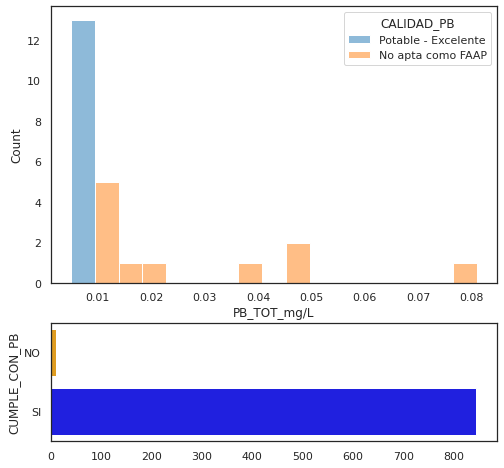

+----+---------------------+----------+---------+-------------+--------+
|    | calidad             | cumple   |     min |        mean |    max |
|----+---------------------+----------+---------+-------------+--------|
|  0 | Potable - Excelente | SI       | 0       | 0.000108387 | 0.0086 |
|  1 | No apta como FAAP   | NO       | 0.01075 | 0.0283791   | 0.0809 |
+----+---------------------+----------+---------+-------------+--------+


In [39]:
analizar_variable({
    'column': 'CUMPLE_CON_PB',
    'dict_key': 'CUMPLE_CON_PB',
    'type': 'classification',
    'classification_dict': {'value': 'PB_TOT_mg/L', 'class': 'CALIDAD_PB'}
})

### Solidos Disueltos


    -----------------------------------------
    Variable: SDT_M_mg/L
    -----------------------------------------
    Descripcion: Valor de Solidos Disueltos Totales-Medidos, en miligramos por litro
    Tipo: pseudonumber
    Nulos: 2
    


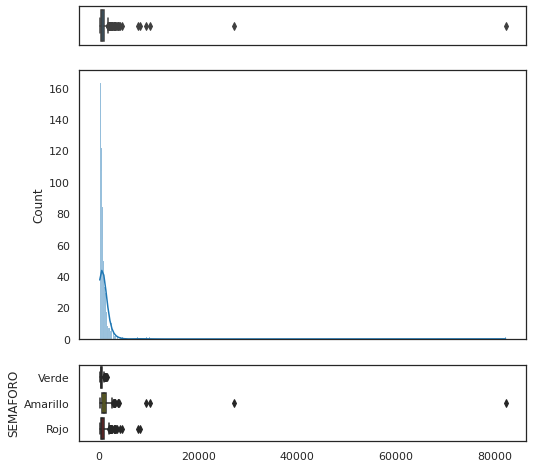

+------------+---------+----------+----------+-------+--------+-------+---------+---------+
|            |   count |     mean |      std |   min |    25% |   50% |     75% |     max |
|------------+---------+----------+----------+-------+--------+-------+---------+---------|
| SDT_M_mg/L |     852 |  907.401 | 3049.85  | 101.2 | 334.7  | 540   |  905.3  | 82170   |
| Verde      |     336 |  452.298 |  229.353 | 101.2 | 280.45 | 396.5 |  586.05 |  1614   |
| Amarillo   |     198 | 1721.25  | 6141.83  | 152   | 613.15 | 909.5 | 1445.95 | 82170   |
| Rojo       |     318 |  881.528 |  915.788 | 139.4 | 351.85 | 579   | 1015.35 |  8230.4 |
+------------+---------+----------+----------+-------+--------+-------+---------+---------+


In [40]:
analizar_variable({
    'column': 'SDT_M_mg/L',
    'dict_key': 'SDT_M_mg/L',
    'type': 'pseudonumber',
})


    -----------------------------------------
    Variable: CUMPLE_CON_SDT_ra
    -----------------------------------------
    Descripcion: Indica si cumple con la calidad de Excelente para riego, Cultivos sensibles o Cultivos con manejo especial, para el Indicador SDT (Riego agr­cola)
    Tipo: classification
    Nulos: 0
    


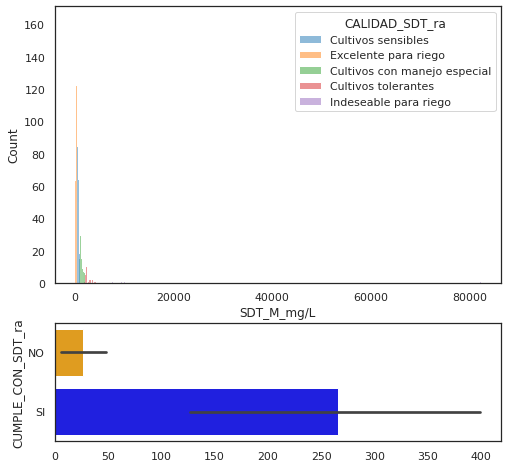

+----+------------------------------+----------+--------+-----------+---------+
|    | calidad                      | cumple   |    min |      mean |     max |
|----+------------------------------+----------+--------+-----------+---------|
|  0 | Excelente para riego         | SI       |    0   |   326.639 |   500   |
|  1 | Cultivos sensibles           | SI       |  500.2 |   713.673 |   999.8 |
|  2 | Cultivos con manejo especial | SI       | 1011.4 |  1369.27  |  1995   |
|  3 | Cultivos tolerantes          | NO       | 2025   |  2687.18  |  4676   |
|  4 | Indeseable para riego        | NO       | 7746   | 24177     | 82170   |
+----+------------------------------+----------+--------+-----------+---------+


In [41]:
analizar_variable({
    'column': 'CUMPLE_CON_SDT_ra',
    'dict_key': 'CUMPLE_CON_SDT_ra',
    'type': 'classification',
    'classification_dict': {'value': 'SDT_M_mg/L', 'class': 'CALIDAD_SDT_ra'}
})


    -----------------------------------------
    Variable: CUMPLE_CON_SDT_salin
    -----------------------------------------
    Descripcion: Indica si cumple con la calidad de Potable - Dulce  o Ligeramente salobres, para el Indicador Solidos Disueltos Totales (Salinizaci½n)
    Tipo: classification
    Nulos: 0
    


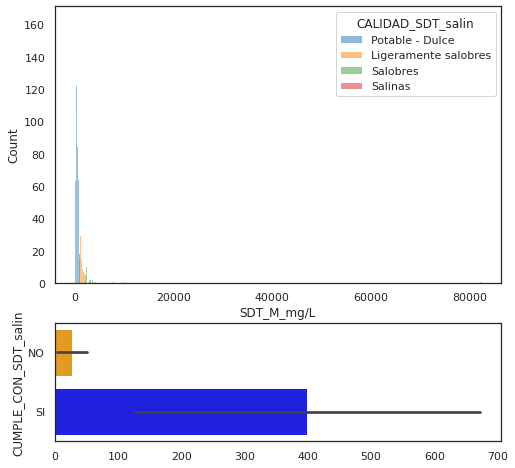

+----+----------------------+----------+---------+-----------+----------+
|    | calidad              | cumple   |     min |      mean |      max |
|----+----------------------+----------+---------+-----------+----------|
|  0 | Potable - Dulce      | SI       |     0   |   483.872 |   999.8  |
|  1 | Ligeramente salobres | SI       |  1011.4 |  1369.27  |  1995    |
|  2 | Salobres             | NO       |  2025   |  3028.72  |  9503.67 |
|  3 | Salinas              | NO       | 10196   | 39860.6   | 82170    |
+----+----------------------+----------+---------+-----------+----------+


In [42]:
analizar_variable({
    'column': 'CUMPLE_CON_SDT_salin',
    'dict_key': 'CUMPLE_CON_SDT_salin',
    'type': 'classification',
    'classification_dict': {'value': 'SDT_M_mg/L', 'class': 'CALIDAD_SDT_salin'}
})

# Pipeline para ML

# Conclusiones